In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import sys
sys.path.append('..')

In [245]:
from state import State
import os
import json
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from utils.order_parameters import (
    calculate_avg_dist,
)
from utils.state_utils import convert_states_to_local
import colorsys
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

RESULTS_DIR = 'results/drones/'
LIPSCHITZ_RESULTS_DIR = 'results/log/swarm/final'
SYNC_RESULTS_DIR = 'results/log/swarm/async'
PLOTS_DIR = '/home/agniewek/repos/papers/2021-ABarcis-MRS-Swarming/data/'

In [411]:
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['axes.grid'] = True

plt.rcParams['legend.fancybox'] = True
#print(plt.rcParams.find_all('axes'))

plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.edgecolor'] = '#b3b3b3'
#plt.rcParams['figure.framealpha'] = 0.5
#plt.tick_params(left=False, bottom=False)
#matplotlib.style.use('default')
#matplotlib.style.use('seaborn-talk')
#matplotlib.style.use('seaborn-whitegrid')

In [409]:

def make_zoom_in_plot(ax, x1, x2, y1, y2, zoom_level=2):
    if zoom_level != 'fixed':
        axins = zoomed_inset_axes(ax, zoom_level, loc=1)
    else:
        axins = inset_axes(ax, 1, 1 , loc=1,
                           bbox_to_anchor=(0.97, 0.95),
                           bbox_transform=ax.figure.transFigure) # no zoom
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.get_xaxis().set_visible(False)
    axins.get_yaxis().set_visible(False)
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    return axins

    
def plot_experiments(plot_data, zoom=None, xlim=None, instants=None, save_name=None, drop_samples_factor=1, ylim=None):
    times = plot_data['ts']

    fig, ax = plt.subplots(
        1, 1, sharex=True, constrained_layout=True, figsize=(5.5, 2.5)
    )
    #fig.suptitle(f"{experiment_name_prefix} {data['params']}")

    #fig.suptitle(filename)
    fig2, s = plt.subplots(1, 3, constrained_layout=True, figsize=(5.5, 2), sharex=True, sharey=True)
    #print(len(times[0]), len(data['centroids']), len(data['var_rs']), len(data['Ss']))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


    ax.set_axisbelow(False)
    #ax.scatter(times, plot_data['S'], s=5, label="$S$")
    #ax.scatter(times, plot_data['potentials'][0])
    # zoom = False
    if zoom:                 
        axins = make_zoom_in_plot(ax, *zoom)
    for i, p in enumerate(plot_data['potentials']):
        ax.plot(times[::drop_samples_factor], p[::drop_samples_factor], 'o', c=colors[i], rasterized=True, markersize=2)
        if zoom:
            axins.scatter(times, p, c=colors[i], s=5)
    
    #ax.spines['left'].set_visible(False)
    #ax.set_ylim(ymin=-0.01)
    snapshots = plot_data['snapshots']
    #print(len(snapshots))
    #print(snapshots)
    if xlim is None:
        xlim = (-times[0]*0.01, times[-1]*1.01)
    if instants is None:
        instants = [0, int(len(snapshots)/2), -1]
    offsets = [xlim[1]*0.01, xlim[1]*0.03, xlim[1]*0.12]
    # instants = []
    
    for i, idx in enumerate(instants):

        t = times[idx]
        ax.axvline(t, color='black', ls='--')
        ax.text(t-offsets[i], 1.01, f'$t={t:.0f}\\:$s', transform=ax.get_xaxis_transform())
        #s[i].xaxis.set_major_locator(MultipleLocator(2))
        #s[i].yaxis.set_major_locator(MultipleLocator(2))
        #s[i].axis('square', anchor='C')
        s[i].set_aspect('equal', adjustable='box', anchor='C')
        # print(data['snapshots'])
        #print(snapshots[i])
        xs = [s.position[0] for s in snapshots[idx]]
        avg_x = np.average(xs)
        ys = [s.position[1] for s in snapshots[idx]]
        avg_y = np.average(ys)
        cs = [colorsys.hsv_to_rgb(s.phase, 1, 1) for s in snapshots[idx]]
        #s[i].set_axisbelow(True)
        #s[i].set_xlim((-30, 30))
        #s[i].set_ylim((-30, 30))
        s[i].set_xlim(s[i].get_ylim())
        for j in range(len(xs)):
            s[i].scatter(xs[j]-avg_x, ys[j]-avg_y, c=colors[j], s=30)
        #s[i].scatter(xs, ys, s=30)
        s[i].set_title(f'$t={t:.0f}\\:$s')
        s[i].set_xlabel('[m]')
        
    s[0].set_ylabel('[m]')
    
    # ax.legend(loc='upper right')
    
    ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ymin=-0.01)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('potential')
    # ax.set_yscale('log')

    
    if save_name:
        path_prefix = os.path.join(PLOTS_DIR, save_name)
        fig.savefig(f'{path_prefix}-pot.eps', bbox_inches="tight", dpi=400)
        fig2.savefig(f'{path_prefix}-snap.pdf', bbox_inches="tight", dpi=400)
    #print(data)
    
    


    
    


In [406]:
robot_names = ['01', '02', '03', '04', '00']
experiments = os.listdir(os.path.join(RESULTS_DIR, 'b01'))
experiments = [experiments[1], experiments[-1]]

sim_lipschitz = os.listdir(LIPSCHITZ_RESULTS_DIR)


def state_from_json(s, params):
    #print(s)
    if not s:
        return s
    params.update({
        'phase_levels_number': s['phase_levels_number'],
        'orientation_mode': s['orientation_mode'],
    })
    state = State(
        phase=s['phase'],
        position=np.array(s['position']),
        velocity=np.array(s['velocity']),
        params=params,
    )
    state.phase_level = s['phase_level']
    return state

def parse_params_from_filename(filename):
    params = {}
    param_string = filename[:-5].split(':')[-1]
    param_strings = param_string.split(',')
    for ps in param_strings:
        param_name, value_string = ps.split('=')
        if param_name == 'M':
            value = int(value_string)
        else:
            value = float(value_string)
        params[param_name] = value
    return params

def get_experiment_raw_data(experiment_name):
    result = {}
    with open(os.path.join(RESULTS_DIR, 'b01', experiment_name)) as f:
        result = json.load(f)
    params = parse_params_from_filename(experiment_name)
    return result, params

def calculate_exp_potential(states):
    N = len(states)
    potentials = []
    a = 0.1
    r = 30
    d = 5
    
    for i, s1 in enumerate(states):
        pot = 0
        x1 = s1.position
        for s2 in states[:i] + states[i+1:]:
            x2 = s2.position
            pot += a * np.linalg.norm(x2-x1)**2/2 - r * np.log(np.linalg.norm(x2-x1) - d)
        potentials.append(pot/N)
    return potentials

def calculate_sim_potential(states):
    N = len(states)
    potentials = []
    a = 0.75
    r = 2
    d = 0.2
    
    for i, s1 in enumerate(states):
        pot = 0
        x1 = s1.position
        for s2 in states[:i] + states[i+1:]:
            x2 = s2.position
            pot += a * np.linalg.norm(x2-x1)**2/2 - r * np.log(np.linalg.norm(x2-x1) - d)
        potentials.append(pot/N)
    return potentials

def get_plot_data(experiments_data, params):
    states = {}
    result = {
        'S': [],
        'potentials': [],
        'snapshots': [],
        'ts': [],
        'params': params
    }
    states['01'] = [state_from_json(s[1]['01'], params) for s in experiments_data['states']]
    #print(states)
    for drone_name in robot_names[1:]:
        #print(experiments_data['knowledge'])
        tmp = [state_from_json(s[1]['01'].get(drone_name, None), params) for s in experiments_data['knowledge']]
        if any(tmp):
            states[drone_name] = tmp
    history = [[(k, states[k][i]) for k in states.keys()] for i in range(len(states['01']))]    
    states_matrix = list(zip(*list(states.values())))
    relative_states = []
    for current_states in history:
        if not all([s[1] for s in current_states]):
            continue
        root = current_states[0]
        own, other = convert_states_to_local(root[1], current_states)
        #root.position = np.zeros(3)
        relative_states.append([s[1] for s in other])
          
    result['S'] = [calculate_avg_dist(current_states) for current_states in relative_states]    
    result['potentials'] = list(zip(*[calculate_exp_potential(current_states) for current_states in relative_states]))
    print(len(result['potentials']))
    result['snapshots'] = relative_states
    result['ts'] = [d[0] for i, d in enumerate(experiments_data['states']) if all(states_matrix[i])]
    return result

def get_raw_data(path, file):
    result = {}
    with open(os.path.join(path, file)) as f:
        result = json.load(f)
    params = parse_params_from_filename(file)
    return result, params

def get_sim_plot_data(sim_data, params):
    result = {
        'potentials': [],
        'snapshots': [],
        'ts': [],
        'params': params,
    }
    states = {k: [state_from_json(s[1][k], params) for s in sim_data['states']] for k in sim_data['states'][0][1].keys()}
    history = [[(k, states[k][i]) for k in states.keys()] for i in range(len(states[next(iter(states))]))]
    states_list = []
    for current_states in history:
        if not all([s[1] for s in current_states]):
            continue
        #root.position = np.zeros(3)
        states_list.append([s[1] for s in current_states])
    result['potentials'] = list(zip(*[calculate_sim_potential(current_states) for current_states in states_list]))
    print(len(result['potentials']))
    result['snapshots'] = states_list
    result['ts'] = [d[0] for i, d in enumerate(sim_data['states']) if all(sim_data['states'][i][1].values())]
    #history = sim_data['states']
    #print(len(history))
    #for t, states in history:
        #for k, s in states.items():
            #states[k] = state_from_json(s, params)
        #if t > maxt[filename]:
        #    break
        #if list(states.values())[0].small_phase == 0:
        #result['ts'].append(t)
        #result['potentials'].append(calculate_potential(list(states.values())))
        #result['snapshots'].append(states)
        #times = ts[filename]
        #instants[filename] = [times[-3], times[-2], times[-1]]
    #result['potentials'] = list(zip(*result['potentials']))
    return result
    
    

In [407]:
sim_lipschitz_plot_data = {}
for experiment in sim_lipschitz:
    print(experiment)
    data, params = get_raw_data(LIPSCHITZ_RESULTS_DIR, experiment)
    if params['T'] != 1:
        sim_lipschitz_plot_data[experiment] = get_sim_plot_data(data, params)

2021-05-16 13:29:03.811882:J=0,K=0,M=1,T=0.2.json
12
2021-05-16 13:33:31.411754:J=0,K=0,M=1,T=3.0.json
12
2021-05-16 13:34:47.234248:J=0,K=0,M=1,T=1.0.json
2021-05-16 13:34:11.210840:J=0,K=0,M=1,T=3.0.json
12
2021-05-16 13:33:06.855115:J=0,K=0,M=1,T=1.0.json
2021-05-16 13:35:37.511288:J=0,K=0,M=1,T=0.2.json
12


2021-05-16 13:29:03.811882:J=0,K=0,M=1,T=0.2.json
2021-05-16 13:33:31.411754:J=0,K=0,M=1,T=3.0.json
2021-05-16 13:34:11.210840:J=0,K=0,M=1,T=3.0.json
2021-05-16 13:35:37.511288:J=0,K=0,M=1,T=0.2.json


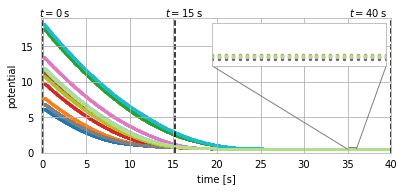

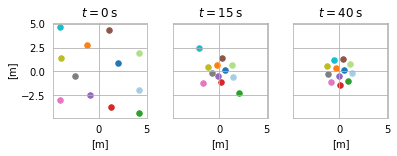

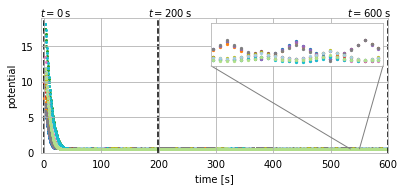

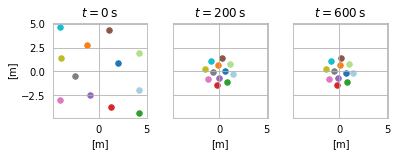

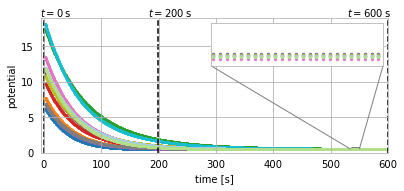

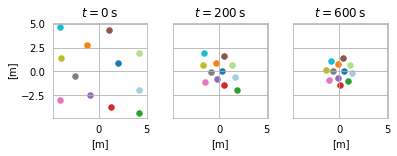

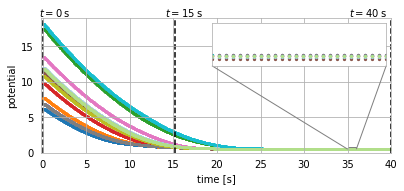

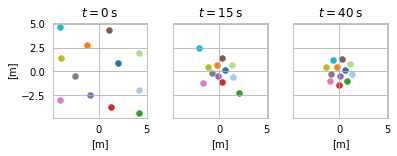

In [412]:
xlims = [
    (-0.2, 40),
    (-5, 600),
    (-5, 600),
    (-0.2, 40),
]

instantss = [
    (0, 380, 1000),
    (0, 333, 1000),
    (0, 333, 1000),
    (0, 380, 1000),
]

zooms = [
    (35, 36, 0.5, 0.8, 20),
    (535, 550, 0.5, 0.8, 20),
    (535, 550, 0.5, 0.8, 20),
    (35, 36, 0.5, 0.8, 20),
]

save_names = [
    "sim-lipschitz-no-short",
    "sim-lipschitz-no-long",
    "sim-lipschitz-yes-long",
    "sim-lipschitz-yes-short",
]

factors = [
    7,
    2,
    6,
    7,
]

for item, xlim, instants, zoom, save_name, factor in zip(sim_lipschitz_plot_data.items(), xlims, instantss, zooms, save_names, factors):
    experiment_name, plot_data = item
    print(experiment_name)
    plot_experiments(plot_data, xlim=xlim, instants=instants, zoom=zoom, save_name=save_name, drop_samples_factor=1, ylim=True)
    
# pierwsze dwa bez lipschitza
# kolejne dwa z lipschitzem

2021-03-17 22:51:34.007815:J=0,K=0,M=1,T=0.5.json
5
2021-03-17 22:46:27.003172:J=0,K=0,M=1,T=0.5.json
4


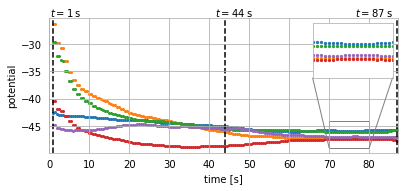

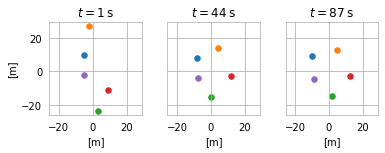

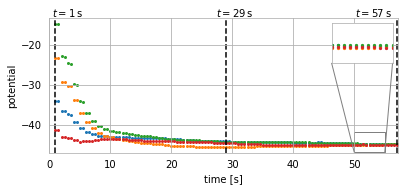

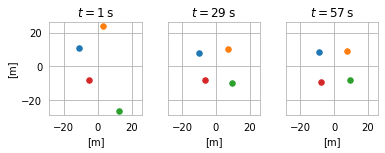

In [413]:
zooms_exp = [
    #(160, 178, -49, -42, 1.5),
    (70, 80, -49, -44),
    #(10, 20, -50, -40),
    #(10, 20, -50, -40),
    (50, 55, -47, -42),
]

save_names = [
    "exp-5",
    "exp-4",
]

xlims = [
    (0, 87.1),
    (0, 57.1),
]


for experiment, zoom, save_name, xlim in zip(experiments, zooms_exp, save_names, xlims):
    print(experiment)
    data, params = get_experiment_raw_data(experiment)
    plot_data = get_plot_data(data, params)
    
    plot_experiments(plot_data, zoom=zoom, save_name=save_name, xlim=xlim)

2021-04-28 17:28:06.347950:J=0,K=0,M=1,T=0.01.json
12
2021-04-28 17:28:28.745012:J=0,K=0,M=1,T=0.01.json
12
2021-04-28 17:28:53.440962:J=0,K=0,M=1,T=0.01.json
12
2021-04-28 17:29:18.848159:J=0,K=0,M=1,T=0.01.json
12


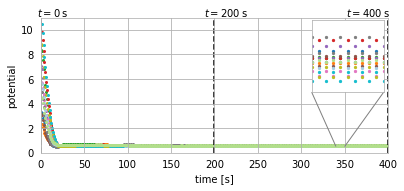

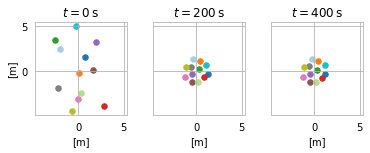

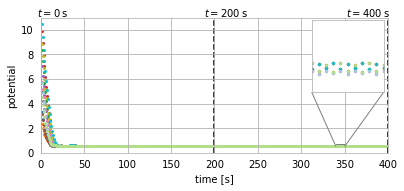

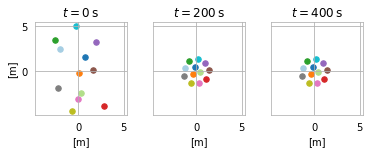

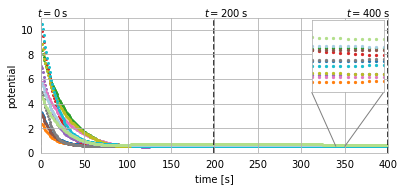

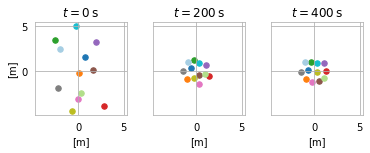

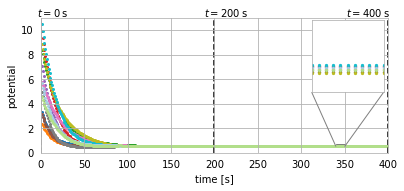

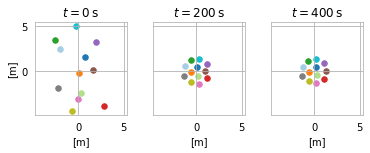

In [414]:
t_end = 400

xlims = [
    (-0, t_end),
]*4

instantss = [
    (0, int(t_end/2), t_end),
]*4


zooms = [
    (340, 350, 0.5, 0.7, 'fixed'),
]*4



async_files = [
    '2021-04-28 17:28:06.347950:J=0,K=0,M=1,T=0.01.json',
    '2021-04-28 17:28:28.745012:J=0,K=0,M=1,T=0.01.json',
    '2021-04-28 17:28:53.440962:J=0,K=0,M=1,T=0.01.json',
    '2021-04-28 17:29:18.848159:J=0,K=0,M=1,T=0.01.json',
]

save_names = [
    "sim-sync-nothing",
    "sim-sync-sync",
    "sim-sync-lipschitz",
    "sim-sync-both",
]

factors = [
    1,
    1,
    2,
    2,
]

for experiment, save_name, xlim, instants, zoom, factor in zip(async_files, save_names, xlims, instantss, zooms, factors):
    print(experiment)
    data, params = get_raw_data(SYNC_RESULTS_DIR, experiment)
    plot_data = get_sim_plot_data(data, params)
    
    plot_experiments(plot_data, save_name=save_name, xlim=xlim, instants=instants, zoom=zoom, drop_samples_factor=1, ylim=True)
